In [1]:
from __future__ import print_function, division
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate, accuracy


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import os

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

In [2]:
input_dir = "C:\\Users\\91958\\devnagari\\"
df = pd.read_csv(input_dir+"data.csv")

In [3]:
df.head()

,pixel_0000,pixel_0001,pixel_0002,pixel_0003,pixel_0004,pixel_0005,pixel_0006,pixel_0007,pixel_0008,pixel_0009,...,pixel_1015,pixel_1016,pixel_1017,pixel_1018,pixel_1019,pixel_1020,pixel_1021,pixel_1022,pixel_1023,character
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka


In [4]:
X=df.iloc[:,:-1]/255
y=df.iloc[:,-1].values

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=42)

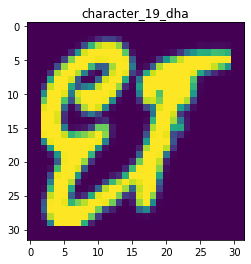

In [5]:
X_train = X_train.values.reshape((X_train.shape[0],32, 32, 1) )


def imshow(ix):
    plt.imshow(np.squeeze(X_train[ix,:,:,0:1])) 
    plt.title(y_train[ix])
    plt.show()
    
imshow(46) 

In [6]:
X_test = X_test.values.reshape((X_test.shape[0],32, 32, 1) )

In [7]:
### label encoder on y_train and y_test

from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y_train=le.fit_transform(y_train)
y_test=le.fit_transform(y_test)

In [8]:
y_train= torch.from_numpy(y_train)

In [9]:
y_train=y_train.type(torch.LongTensor)

In [10]:
y_train.type()

'torch.LongTensor'

In [11]:
train_Aug = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),       
                                            torchvision.transforms.ToTensor()])
test_Aug = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),  
                                           torchvision.transforms.ToTensor()])

In [12]:
class MyDataset():
    def __init__(self ,X_train , y_train, c,  transforms=None):

        self.y_train = y_train
        self.X_train = X_train
        self.c = c
        self.transforms = transforms
    
    def __getitem__(self,idx):
        label = self.y_train[idx]
        image = Image.fromarray(np.squeeze(self.X_train[idx,:,:,0:3])).convert('RGB')
        c= self.c
        
        if self.transforms is not None:
              image = self.transforms(image)
        return image, label
    
    def __len__(self):
        return len(self.y_train)
    

unique_char = df['character'].unique()
c= len(unique_char)
print(c)
dataset = MyDataset(X_train , y_train, c, train_Aug) 

46


In [13]:
from torch.utils.data import Dataset, DataLoader ,random_split
from PIL import Image

from torch.utils.data import Dataset, DataLoader ,random_split
valid_no = int(len(dataset)*0.2) 
trainset ,valset  = random_split( dataset , [len(dataset) -valid_no  ,valid_no])

print(len(trainset), len(valset))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0)
validloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

51520 12880


In [14]:
data = DataBunch(train_dl = trainloader, valid_dl = validloader)

In [15]:
data.c = 46

In [16]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)   


#### learn.loss_func = F.cross_entropy     set this up manually. Why? Take a look at last code cell.

In [21]:
learn.fit_one_cycle(2, 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,-16194.853516,-18544.500000,0.691925,08:14
1,-35677.140625,-35932.066406,0.743866,08:18


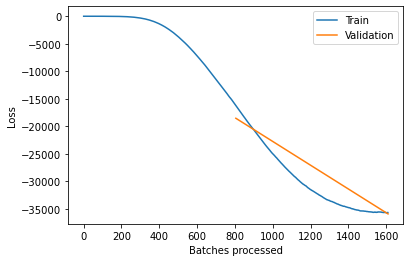

In [22]:
learn.recorder.plot_losses()

In [ ]:
#############  must Read!!  About negative loss  ##########################




# I think I have got it. So the thing is Fastai library sets up the loss_func
# properly while creating the labels. While creating labels at one point you will hit 
# this function [label_from_list] (https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L178 1)
# Now this function is calling [get_label_cls](https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L168) 
# and there they are setting up the List type (MultiCategoryList, FloatList, CategoryList) 
# In case of multi-class classification we end up with having CategoryList.
# In this class we have self.loss_func = F.cross_entropy
# (https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L245 1)

# Now when we created the custom dataset with DataBunch.create method, 
# this label function was not called and hence Fastai library added default loss function which is F.nll_loss.

# @wyquek (and me) already have discussed how F.nll_loss(F.log_softmax(inp), out) == F.cross_entropy(inp, out)
# Which is F.cross_entropy applying F.log_softmax automatically but in case of F.nll_loss we need to apply that manually. 
# And when you don’t apply F.log_softmax result can be negative. So it is a good idea to give a look at your loss function
# and pondering whether you are getting desired loss function or not! :slight_smile:

# (Now it would be really great if someone from fastai can confirm my findings! :slight_smile: )

# Two solutions for this:

# Apply F.log_softmax on inputs before feeding them to F.nll_loss
# An easy solution is set loss function manually. learn.loss_func = F.cross_entropy